In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import main.dataprep as dp
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def get_data_for_transformer(df: pd.DataFrame, y_feature: str='CO2', window_size: int=20, aggregation_level: str = 'quarter_hour', batch_size: int=get_batch_size(), clean_data: bool=True) -> np.array:
    """
    args:   df: pd.DataFrame
            y_feature: str
            window_size: int
            aggregation_level: str, one of "hour", "half_hour", "quarter_hour"

    returns: np.array
    """
    # use data cleaning from prepare_data_for_plot function
    df_cpy = prepare_data_for_plot(df, clean_data)

    if aggregation_level == "hour":
        df_cpy['date_time'] = df_cpy['date_time'].dt.round('60T')
    elif aggregation_level == "half_hour":
        df_cpy['date_time'] = df_cpy['date_time'].dt.round('30T')
    elif aggregation_level == "quarter_hour":
        df_cpy['date_time'] = df_cpy['date_time'].dt.round('15T')
    else:
        raise ValueError("Invalid aggregation_level. Please choose one of 'hour', 'half_hour', or 'quarter_hour'.")


    df_cpy = df_cpy[['device_id', 'date_time', y_feature]]

    df_cpy = df_cpy.groupby(['device_id', 'date_time']).mean().reset_index()
    
    # create 'consecutive_data_point' thats 1 if the previous data point is 1 hour before the current data point and device_id is the same, else 0
    time_delta = 3600 if aggregation_level == 'hour' else 1800 if aggregation_level == 'half_hour' else 900
    df_cpy['consecutive_data_point'] = (df_cpy['date_time'] - df_cpy['date_time'].shift(1)).dt.total_seconds() == time_delta
    df_cpy['consecutive_data_point'] = df_cpy['consecutive_data_point'].astype(int)
    
    # Identify changes and resets (when the value is '0' or there's a change in 'device_id')
    df_cpy['reset'] = (df_cpy['consecutive_data_point'] == 0) | (df_cpy['device_id'] != df_cpy['device_id'].shift(1))

    # Create a group identifier that increments every time a reset occurs
    df_cpy['group'] = df_cpy['reset'].cumsum()

    # Calculate cumulative sum of "1"s within each group
    df_cpy['consecutive_data_points'] = df_cpy.groupby(['device_id', 'group'])['consecutive_data_point'].cumsum() - df_cpy['consecutive_data_point']
    df_cpy['group_size'] = df_cpy.groupby(['device_id', 'group'])['consecutive_data_point'].transform('count')

    df_cpy = df_cpy[df_cpy['group_size'] > window_size]

    # You may want to drop the 'reset' and 'group' columns if they are no longer needed
    df_cpy.drop(['reset', 'consecutive_data_point', 'consecutive_data_points', 'group_size'], axis=1, inplace=True)
    
    threshold_date = df_cpy.sort_values('date_time', ascending=True)['date_time'].quantile(0.8)
    print('training data cutoff: ', threshold_date)

    df_train = df_cpy[df_cpy['date_time'] < threshold_date]
    df_test = df_cpy[df_cpy['date_time'] >= threshold_date]

    # Create the scaler instance
    scaler = StandardScaler()

    # Fit on training data and transform both training and test data
    df_train[f'{y_feature}_scaled'] = scaler.fit_transform(df_train[[y_feature]])
    df_test[f'{y_feature}_scaled'] = scaler.transform(df_test[[y_feature]])

    def to_sequences(seq_size: int, obs: pd.DataFrame):
        x = []
        y = []
        for g_id in obs['group'].unique():
            group_df = obs[obs['group'] == g_id]
            feature_values = group_df[f'{y_feature}_scaled'].to_numpy().reshape(-1, 1).flatten().tolist()
            for i in range(len(feature_values) - seq_size):
                window = feature_values[i:(i + seq_size)]
                after_window = feature_values[i + seq_size]
                x.append(window)
                y.append(after_window)
        return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

    x_train, y_train = to_sequences(window_size, df_train)
    x_test, y_test = to_sequences(window_size, df_test)

    print("Training data shape:", x_train.shape, y_train.shape)
    print("Testing data shape:", x_test.shape, y_test.shape)

    # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    return train_dataset, test_dataset, train_loader, test_loader, scaler, y_test


In [23]:
df = pd.read_csv('main/aggregated_hourly.csv')
df.date_time = pd.to_datetime(df.date_time)
df = df[['device_id', 'date_time', 'CO2','tmp',"hum","VOC"]]
timedelta = 3600
df['consecutive_data_point'] = (df['date_time'] - df['date_time'].shift(1)).dt.total_seconds() == timedelta
df['consecutive_data_point'] = df['consecutive_data_point'].astype(int)
df['reset'] = (df['consecutive_data_point'] == 0) | (df['device_id'] != df['device_id'].shift(1))
df['group'] = df['reset'].cumsum()
df['consecutive_data_points'] = df.groupby(['device_id', 'group'])['consecutive_data_point'].cumsum() - df['consecutive_data_point']
df.head(5)

,device_id,date_time,CO2,tmp,hum,VOC,consecutive_data_point,reset,group,consecutive_data_points
0,hka-aqm-a014,2022-10-10 14:00:00,532,23.902895,47.4050,464,0,True,1,0
1,hka-aqm-a014,2022-10-10 15:00:00,509,24.793750,43.1975,477,1,False,1,0
2,hka-aqm-a014,2022-10-10 16:00:00,477,24.856000,44.1520,535,1,False,1,1
3,hka-aqm-a014,2022-10-10 17:00:00,493,24.860000,45.9825,566,1,False,1,2
4,hka-aqm-a014,2022-10-10 18:00:00,512,24.824000,48.7540,744,1,False,1,3


In [24]:
df['group_size'] = df.groupby(['device_id', 'group'])['consecutive_data_point'].transform('count')
window_size = 50
df.loc[df['reset'] == True]
df_cpy = df[df['group_size'] > window_size]
df_cpy.drop(['reset', 'consecutive_data_point', 'consecutive_data_points', 'group_size'], axis=1, inplace=True)
df_cpy

C:\Users\paulh\AppData\Local\Temp\ipykernel_11352\2705716603.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cpy.drop(['reset', 'consecutive_data_point', 'consecutive_data_points', 'group_size'], axis=1, inplace=True)


,device_id,date_time,CO2,tmp,hum,VOC,group
0,hka-aqm-a014,2022-10-10 14:00:00,532,23.902895,47.4050,464,1
1,hka-aqm-a014,2022-10-10 15:00:00,509,24.793750,43.1975,477,1
2,hka-aqm-a014,2022-10-10 16:00:00,477,24.856000,44.1520,535,1
3,hka-aqm-a014,2022-10-10 17:00:00,493,24.860000,45.9825,566,1
4,hka-aqm-a014,2022-10-10 18:00:00,512,24.824000,48.7540,744,1
...,...,...,...,...,...,...,...
143833,hka-aqm-am308,2023-09-26 19:00:00,518,27.580000,36.9175,955,681
143834,hka-aqm-am308,2023-09-26 20:00:00,524,27.512500,37.1425,964,681
143835,hka-aqm-am308,2023-09-26 21:00:00,522,27.462500,37.3400,983,681
143836,hka-aqm-am308,2023-09-26 22:00:00,528,27.392500,37.5125,966,681


In [25]:
threshold_date = df_cpy.sort_values('date_time', ascending=True)['date_time'].quantile(0.8)
print('training data cutoff: ', threshold_date)
df_train = df_cpy[df_cpy['date_time'] < threshold_date]
df_test = df_cpy[df_cpy['date_time'] >= threshold_date]

training data cutoff:  2023-07-16 18:00:00


In [68]:
def to_sequences(obs: pd.DataFrame):
        x = []
        y = []
        seq_size = 50
        #X_new = torch.stack([torch.cat((torch.zeros(window_size-i, X.shape[1]), X[:i])) if i < window_size else X[i-window_size:i] for i in range(0, len(X))])
        for g_id in obs['group'].unique():
            group_df = obs[obs['group'] == g_id]
            for i in range(len(group_df) - seq_size):
                window = group_df[i:(i + seq_size)]
                x.append(window[["CO2","tmp","hum","VOC"]].values)
            y.extend(group_df['tmp'].iloc[seq_size:])       
        return torch.tensor(np.array(x), dtype=torch.float32).view(-1, seq_size, 4), torch.tensor(y, dtype=torch.float32).view(-1, 1)
#to_sequences(df_train)
x_train, y_train = to_sequences(df_train)
x_test, y_test = to_sequences(df_test)

print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)

Training data shape: torch.Size([98963, 50, 4]) torch.Size([98963, 1])
Testing data shape: torch.Size([24699, 50, 4]) torch.Size([24699, 1])


In [82]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

In [2]:
df = pd.read_csv('main/aggregated_hourly.csv')
a0 = ["hka-aqm-a017", "hka-aqm-a014"]
a1 = ["hka-aqm-a101", "hka-aqm-a102", "hka-aqm-a103", "hka-aqm-a106", "hka-aqm-a107", "hka-aqm-a108", "hka-aqm-a111", "hka-aqm-a112"]
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_cutoff = df.copy
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_mean = dp.build_lvl_df(df_cutoff, a1, ["tmp", "hum", "CO2", "VOC"], reset_ind= True)

In [3]:
X = df_mean.to_numpy()
y = df_mean["tmp"].shift(-1).to_numpy()
X_train, X_test, y_train, y_test = dp.train_test_split(X, y,train_size=0.95)
X_train_new, X_test_new = dp.format_tensor(X_train,window_size=100), dp.format_tensor(X_test,window_size=100)
y_train = y_train[:-1]#.unsqueeze(1)
y_test = y_test[:-1]#.unsqueeze(1)
X_train_new.shape, X_test_new.shape, y_train.shape, y_test.shape

(torch.Size([1685, 100, 4]),
 torch.Size([88, 100, 4]),
 torch.Size([1685]),
 torch.Size([88]))

In [4]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_data = TensorDataset(X_train_new, y_train)
test_data = TensorDataset(X_test_new, y_test)

#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [83]:
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [79]:
train_dataset[0]

(tensor([[532.0000,  23.9029,  47.4050, 464.0000],
         [509.0000,  24.7938,  43.1975, 477.0000],
         [477.0000,  24.8560,  44.1520, 535.0000],
         [493.0000,  24.8600,  45.9825, 566.0000],
         [512.0000,  24.8240,  48.7540, 744.0000],
         [527.0000,  24.7100,  49.6300, 676.0000],
         [534.0000,  24.4900,  50.6175, 694.0000],
         [506.0000,  24.3850,  51.2050, 641.0000],
         [500.0000,  24.1400,  52.0450, 623.0000],
         [495.0000,  23.9950,  51.3250, 629.0000],
         [499.0000,  23.9950,  51.2775, 629.0000],
         [505.0000,  23.9875,  50.4600, 591.0000],
         [506.0000,  23.9567,  50.3233, 616.0000],
         [501.0000,  23.9450,  50.0700, 626.0000],
         [499.0000,  23.9425,  49.7975, 612.0000],
         [501.0000,  23.9250,  48.3700, 627.0000],
         [494.0000,  23.9280,  46.9220, 627.0000],
         [510.0000,  23.9500,  45.9600, 621.0000],
         [496.0000,  23.8225,  43.9525, 621.0000],
         [488.0000,  23.7400,  

In [91]:
# Train Decoder
from torch.optim import Adam
from torch.nn import MSELoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a Decoder
Decoder1 = TransformerModel(input_dim=train_dataset[0][0].shape[1])

c:\Users\paulh\anaconda3\envs\Iot\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [85]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 50, 4])
torch.Size([64, 1])


In [89]:
df_train.isna().sum()

device_id    0
date_time    0
CO2          0
tmp          0
hum          0
VOC          0
group        0
dtype: int64

In [123]:
# Train the Decoder
import torch
import time

# Move model to GPU
Decoder1 = Decoder1.to(device)

# Define the number of epochs
num_epochs = 10

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Decoder1.parameters(), lr=0.00005
)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

Decoder1.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        # Move tensors to GPU
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        output = Decoder1(x)
        loss = criterion(output, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Decay the learning rate
    scheduler.step()

    print(f'Epoch: {epoch + 1:03d}, Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch: 001, Loss: 13.5335, Learning Rate: 0.000050
Epoch: 002, Loss: 7.7284, Learning Rate: 0.000048
Epoch: 003, Loss: 16.8522, Learning Rate: 0.000048
Epoch: 004, Loss: 15.4454, Learning Rate: 0.000045
Epoch: 005, Loss: 5.2308, Learning Rate: 0.000045
Epoch: 006, Loss: 4.8755, Learning Rate: 0.000043
Epoch: 007, Loss: 9.8789, Learning Rate: 0.000043
Epoch: 008, Loss: 8.3781, Learning Rate: 0.000041
Epoch: 009, Loss: 6.5262, Learning Rate: 0.000041
Epoch: 010, Loss: 11.1219, Learning Rate: 0.000039


In [150]:
Decoder1.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        output = Decoder1(x)
        y_pred.append(output)
        y_true.append(y)


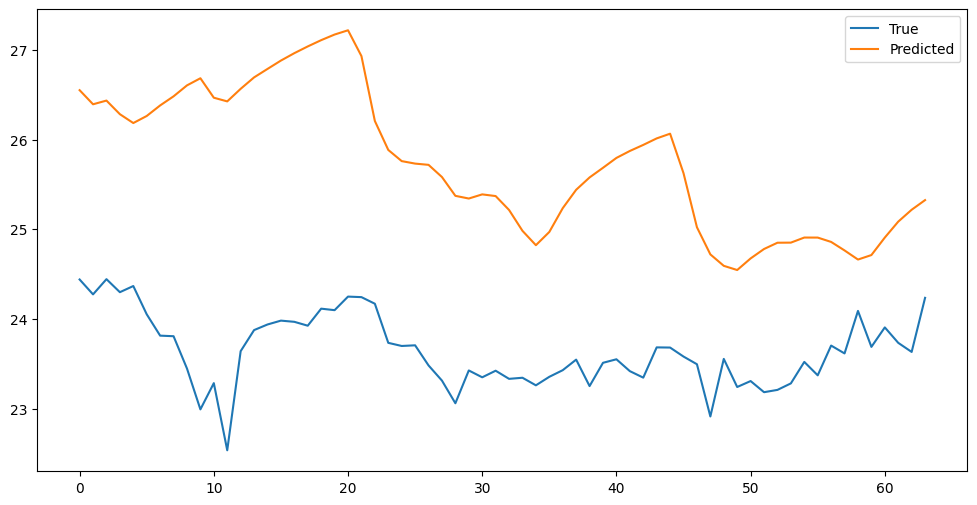

In [154]:
# Only keep the last batch
y_pred_plot = y_pred[-12].cpu().numpy()
y_true_plot = y_true[-12].numpy()  # convert true labels to numpy array

plt.figure(figsize=(12, 6))
plt.plot(y_pred_plot, label='True')
plt.plot(y_true_plot, label='Predicted')
plt.legend()
plt.show()

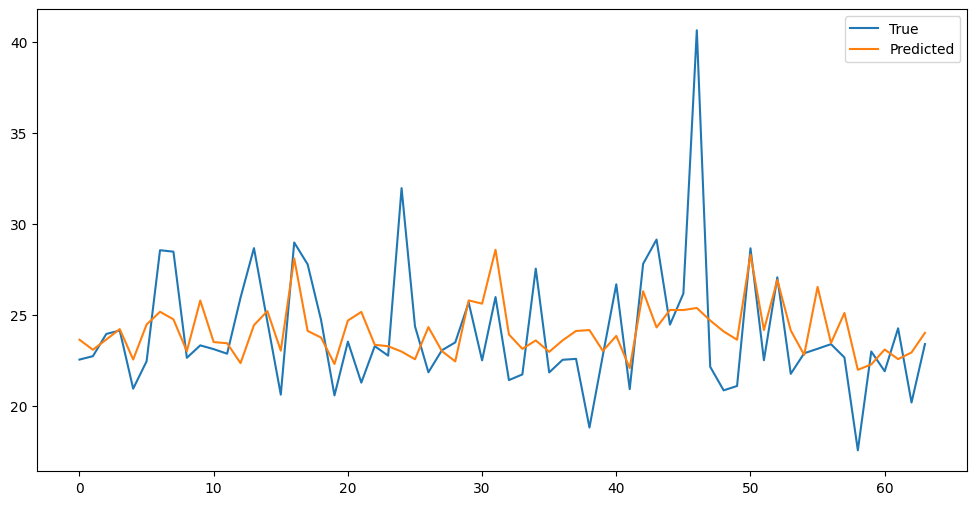

In [132]:
Decoder1.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in train_loader:  # use train_loader instead of test_loader
        x = x.to(device)
        output = Decoder1(x)
        y_pred.append(output)
        y_true.append(y)  # save true labels

# Only keep the last batch
y_pred_plot = y_pred[-5].cpu().numpy()
y_true_plot = y_true[-5].numpy()  # convert true labels to numpy array

plt.figure(figsize=(12, 6))
plt.plot(y_true_plot, label='True')
plt.plot(y_pred_plot, label='Predicted')
plt.legend()
plt.show()

In [133]:
class LSTM_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5, activation='relu'):
        super(LSTM_1, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation_function = activation

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function, choose from 'relu', 'tanh', or 'sigmoid'")

        # self.optimizer = optim.Adam(self.parameters(), lr=0.001)  # Erhöhte Lernrate für schnellere Konvergenz

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Dropout für Regularisierung
        out = self.fc(out)
        out = self.activation(out)  # Aktivierungsfunktion anwenden
        return out

In [134]:
# Train Decoder
from torch.optim import Adam
from torch.nn import MSELoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a Decoder
Lstm = LSTM_1(input_size=4, hidden_size=64, num_layers=2, output_size=1, dropout=0.2, activation='relu')

In [137]:
Lstm = Lstm.to(device)

# Define the number of epochs
num_epochs = 10

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Lstm.parameters(), lr=0.0003
)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

Lstm.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        # Move tensors to GPU
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        output = Lstm(x)
        loss = criterion(output, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Decay the learning rate
    scheduler.step()

    print(f'Epoch: {epoch + 1:03d}, Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch: 001, Loss: 2.2401, Learning Rate: 0.000300
Epoch: 002, Loss: 1.6898, Learning Rate: 0.000285
Epoch: 003, Loss: 2.4296, Learning Rate: 0.000285
Epoch: 004, Loss: 2.8128, Learning Rate: 0.000271
Epoch: 005, Loss: 3.0088, Learning Rate: 0.000271
Epoch: 006, Loss: 2.1681, Learning Rate: 0.000257
Epoch: 007, Loss: 2.3682, Learning Rate: 0.000257
Epoch: 008, Loss: 4.5719, Learning Rate: 0.000244
Epoch: 009, Loss: 0.8432, Learning Rate: 0.000244
Epoch: 010, Loss: 5.5094, Learning Rate: 0.000232


In [147]:
Lstm.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        output = Decoder1(x)
        y_pred.append(output)
        y_true.append(y)


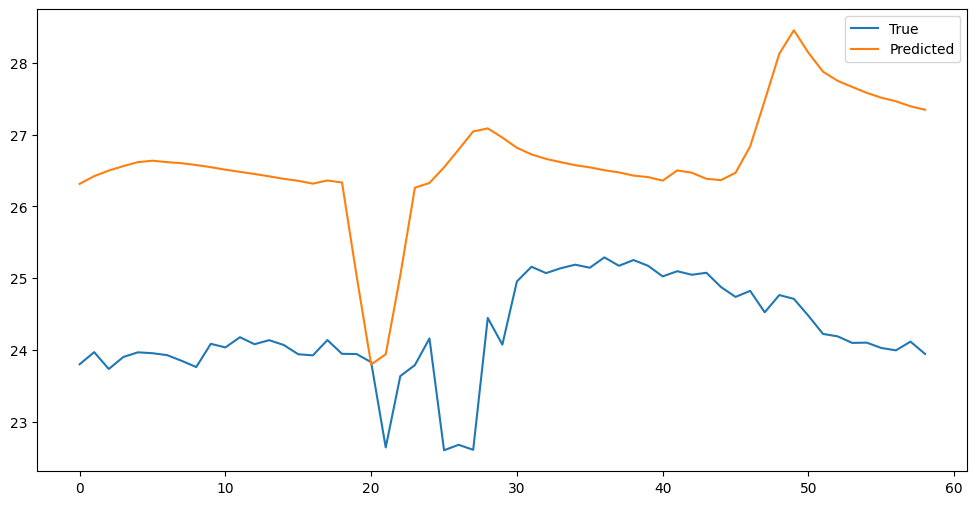

In [148]:
# Only keep the last batch
y_pred_plot = y_pred[-1].cpu().numpy()
y_true_plot = y_true[-1].numpy()  # convert true labels to numpy array

plt.figure(figsize=(12, 6))
plt.plot(y_pred_plot, label='True')
plt.plot(y_true_plot, label='Predicted')
plt.legend()
plt.show()

In [144]:
Decoder1.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in train_loader:  # use train_loader instead of test_loader
        x = x.to(device)
        output = Decoder1(x)
        y_pred.append(output)
        y_true.append(y)  # save true labels

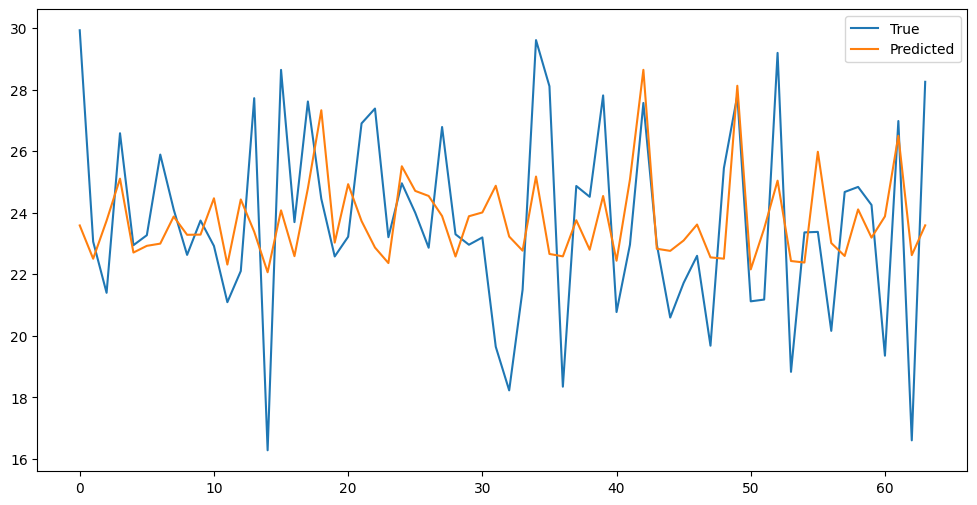

In [145]:
# Only keep the last batch
y_pred_plot = y_pred[-5].cpu().numpy()
y_true_plot = y_true[-5].numpy()  # convert true labels to numpy array

plt.figure(figsize=(12, 6))
plt.plot(y_true_plot, label='True')
plt.plot(y_pred_plot, label='Predicted')
plt.legend()
plt.show()